# 1. Import Libraries

In [1]:
# Common libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf

# preprocessing data
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# MOdel
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense,Conv2D, MaxPool2D, Dropout, GlobalAveragePooling2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Metrics
from tensorflow_addons.metrics import F1Score
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision, Recall


# 2. Load & Preprocessing Data 

In [2]:
train_df = pd.read_csv("../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")

In [3]:
train_df.shape

(27455, 785)

In [4]:
NUM_CLASSES = train_df['label'].nunique()
# sorted(train_df['label'].unique())

In [5]:
train_df['label'].value_counts()

17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
3     1196
14    1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

In [6]:
class_labels = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 10:'K', 11:'L', 12:'M', 
               13:'N', 14:'O', 15:'P', 16:'Q', 17:'R', 18:'S', 19:'T', 20:'U', 21:'V', 22:'W', 23:'X', 24:'Y',}
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J' ,'K', 'L', 'M', 
               'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

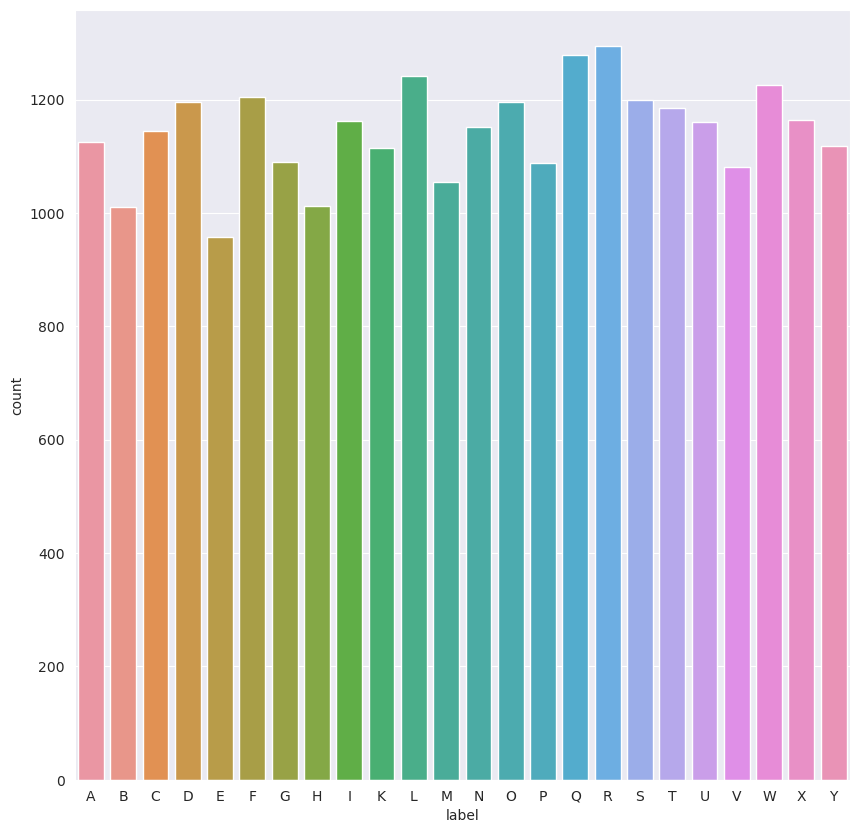

In [7]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df,x = 'label')
plt.xticks(list(np.arange(0,24)),class_labels.values())
plt.show()

## 2.1 preprocession
 - Normalize
 - LabelBinarizer
 - Reshape Data

In [8]:
#Normalize / scale X values
X_train = train_df.iloc[:, 1:].values /255.0
X_test = test_df.iloc[:, 1:].values /255.0

#No need to do this if using sparse categorical cross entropy
y_train = train_df.iloc[:, 0]
y_test = test_df.iloc[:,0]

lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)
y_test_lb = lb.fit_transform(y_test)

#Reshape for the neural network
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

## 2.2 Visualize Data

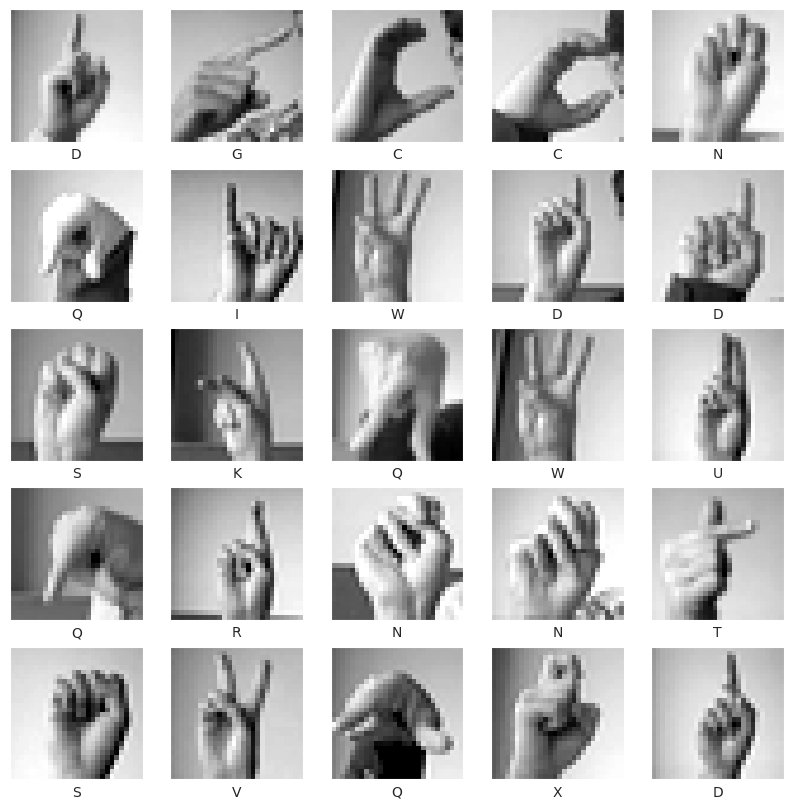

In [9]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap="gray")
    plt.xlabel(class_names[y_train[i]])
plt.show()

## 2.3 Data Augmentaion

In [10]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,   
        samplewise_std_normalization=False,   
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1,
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        horizontal_flip=False,  
        vertical_flip=False)  
datagen.fit(X_train)

# 3. Model Building

In [11]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1), strides = 1, padding = 'same'))

model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same'))

model.add(Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu'))

model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(NUM_CLASSES, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

## 3.1 Configure Model

In [12]:
callbacks = [
    EarlyStopping(min_delta=1e-5, patience=5),
    ModelCheckpoint('Sing_language_model.h5', save_best_only=True)
]
metrics = [
    CategoricalAccuracy(), 
    F1Score(num_classes=NUM_CLASSES), 
    Precision(), 
    Recall(), 
    AUC()
]
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metrics)

## 3.2 Training Model

In [13]:
history = model.fit(datagen.flow(X_train,y_train_lb, batch_size = 128) ,
                    epochs = 30 , validation_data = (X_test, y_test_lb) , 
                    callbacks = callbacks)

Epoch 1/30


2023-05-02 16:03:08.507138: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


215/215 [==============================] - 19s 49ms/step - loss: 1.1653 - categorical_accuracy: 0.6533 - f1_score: 0.6527 - precision: 0.8520 - recall: 0.5317 - auc: 0.9611 - val_loss: 17.4223 - val_categorical_accuracy: 0.0342 - val_f1_score: 0.0028 - val_precision: 0.0342 - val_recall: 0.0342 - val_auc: 0.4961
Epoch 2/30
215/215 [==============================] - 11s 50ms/step - loss: 0.2452 - categorical_accuracy: 0.9208 - f1_score: 0.9204 - precision: 0.9433 - recall: 0.9001 - auc: 0.9977 - val_loss: 8.1915 - val_categorical_accuracy: 0.1309 - val_f1_score: 0.1507 - val_precision: 0.1214 - val_recall: 0.1127 - val_auc: 0.6266
Epoch 3/30
215/215 [==============================] - 10s 44ms/step - loss: 0.1155 - categorical_accuracy: 0.9638 - f1_score: 0.9637 - precision: 0.9705 - recall: 0.9575 - auc: 0.9992 - val_loss: 0.1225 - val_categorical_accuracy: 0.9675 - val_f1_score: 0.9658 - val_precision: 0.9773 - val_recall: 0.9537 - val_auc: 0.9998
Epoch 4/30
215/215 [==================

In [14]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,categorical_accuracy,f1_score,precision,recall,auc,val_loss,val_categorical_accuracy,val_f1_score,val_precision,val_recall,val_auc
0,1.165313,0.653251,"[0.62377506, 0.7098446, 0.79038715, 0.5816282,...",0.851982,0.531670,0.961101,17.422348,0.034161,"[0.0, 0.0, 0.0, 0.06606445, 0.0, 0.0, 0.0, 0.0...",0.034161,0.034161,0.496084
1,0.245224,0.920779,"[0.92225677, 0.95868593, 0.97382194, 0.8967254...",0.943278,0.900091,0.997665,8.191506,0.130926,"[0.075581394, 0.15019763, 0.49881238, 0.076193...",0.121358,0.112660,0.626593
2,0.115506,0.963795,"[0.971606, 0.9836715, 0.98333335, 0.94947803, ...",0.970467,0.957494,0.999248,0.122451,0.967513,"[0.9596412, 0.99769056, 0.9983845, 0.9575758, ...",0.977282,0.953709,0.999779
3,0.068620,0.978073,"[0.9769094, 0.99056137, 0.99126637, 0.9703053,...",0.981448,0.975014,0.999654,0.832876,0.759063,"[0.9339774, 0.79558015, 0.91042584, 0.81927705...",0.773115,0.744980,0.973954
4,0.048396,0.985540,"[0.9884854, 0.9886195, 0.99300086, 0.98285234,...",0.987390,0.983974,0.999684,0.126806,0.957892,"[0.95418644, 1.0, 0.93373495, 0.88888896, 0.98...",0.960230,0.956079,0.998235


In [15]:
history_df['f1_score'] = history_df['f1_score'].apply(np.mean)
history_df['val_f1_score'] = history_df['val_f1_score'].apply(np.mean)

## 3.3 Plot Accuracy

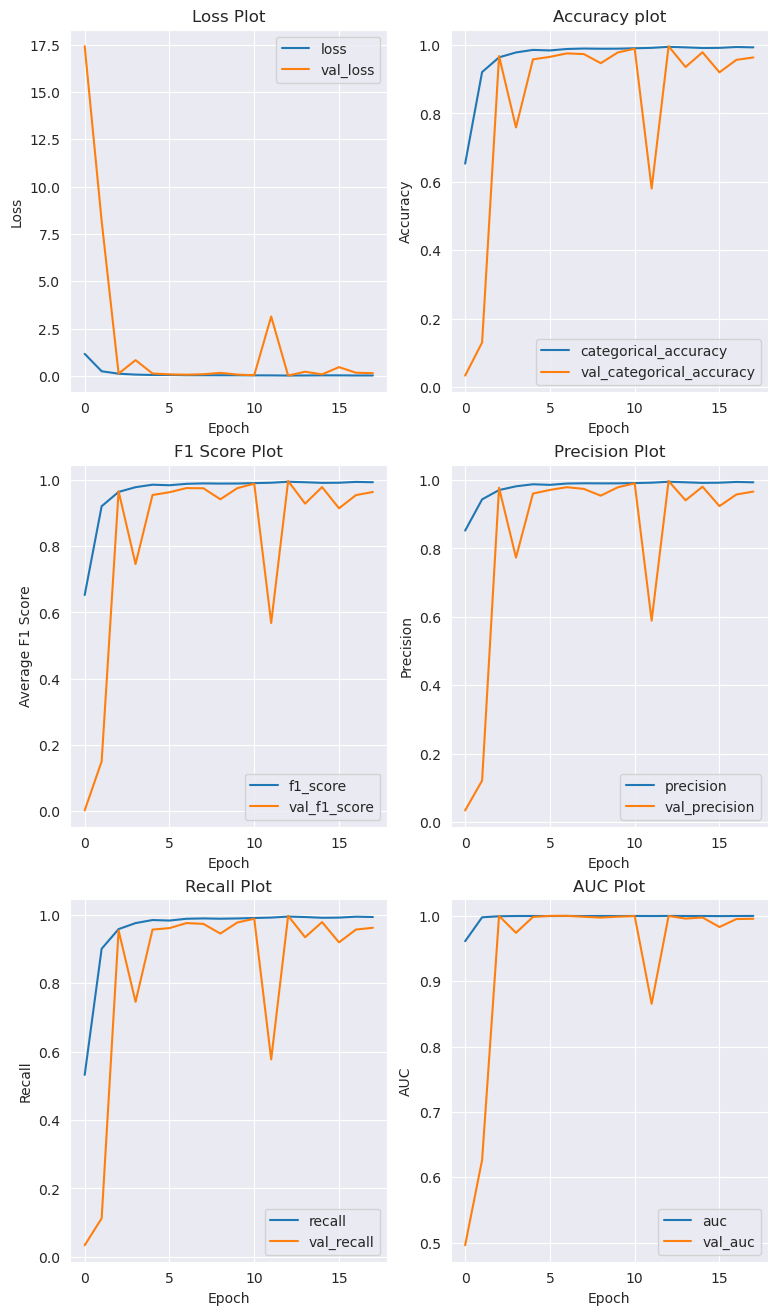

In [16]:
fig, ax = plt.subplots(figsize=(9,16), nrows=3,ncols=2)
history_df[['loss','val_loss']].plot(ax=ax[0,0], xlabel='Epoch',ylabel='Loss', title='Loss Plot')
history_df[['categorical_accuracy','val_categorical_accuracy']].plot(
    ax=ax[0,1], xlabel='Epoch',ylabel='Accuracy',title='Accuracy plot')
history_df[['f1_score','val_f1_score']].plot(ax=ax[1,0],xlabel='Epoch',ylabel='Average F1 Score',title='F1 Score Plot')
history_df[['precision','val_precision']].plot(ax=ax[1,1],xlabel='Epoch',ylabel='Precision',title='Precision Plot')
history_df[['recall','val_recall']].plot(ax=ax[2,0],xlabel='Epoch',ylabel='Recall',title='Recall Plot')
history_df[['auc','val_auc']].plot(ax=ax[2,1],xlabel='Epoch',ylabel='AUC',title='AUC Plot')
plt.show()

# 4. Evaluating The Model

In [17]:
best_model = load_model('/kaggle/working/Sing_language_model.h5')

In [18]:
test_loss,test_acc, test_f1,test_precision, test_recall, test_auc = best_model.evaluate(X_test,  y_test_lb, verbose=2)
predictions = best_model.predict(X_test)
test_preds =predictions.argmax(axis=1)

225/225 - 1s - loss: 0.0155 - categorical_accuracy: 0.9964 - f1_score: 0.9966 - precision: 0.9969 - recall: 0.9962 - auc: 0.9997 - 1s/epoch - 5ms/step
225/225 [==============================] - 1s 2ms/step


In [19]:
test_df['Label_name'] = test_df['label'].map(class_labels)
test_df['Predicted'] = test_preds 
test_df.loc[test_df['Predicted']>8, 'Predicted'] += 1 
test_df['Predicted_name'] = test_df['Predicted'].map(class_labels)
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Label_name,Predicted,Predicted_name
0,6,149,149,150,150,150,151,151,150,151,...,89,82,96,106,112,120,107,G,6,G
1,5,126,128,131,132,133,134,135,135,136,...,183,186,184,184,184,182,180,F,5,F
2,10,85,88,92,96,105,123,135,143,147,...,227,230,227,226,225,224,222,K,10,K
3,0,203,205,207,206,207,209,210,209,210,...,248,253,236,230,240,253,255,A,0,A
4,3,188,191,193,195,199,201,202,203,203,...,48,29,46,49,46,46,53,D,3,D


In [20]:
print("Accuracy of the model is - " , model.evaluate(X_test, y_test_lb)[1]*100 , "%")

225/225 [==============================] - 1s 4ms/step - loss: 0.1439 - categorical_accuracy: 0.9635 - f1_score: 0.9635 - precision: 0.9661 - recall: 0.9614 - auc: 0.9954
Accuracy of the model is -  96.34690284729004 %


In [21]:
conf_mat = confusion_matrix(y_true=test_df['Label_name'], y_pred=test_df['Predicted_name'])
conf_mat = pd.DataFrame(conf_mat,index=class_labels.values(),columns=class_labels.values())
conf_mat

,A,B,C,D,E,F,G,H,I,K,...,P,Q,R,S,T,U,V,W,X,Y
A,331,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B,0,432,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C,0,0,310,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D,0,0,0,245,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,498,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
F,0,0,0,0,0,247,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,329,0,0,0,...,0,0,0,0,0,0,0,0,0,17
H,0,0,0,0,0,0,0,436,0,0,...,0,0,0,0,0,0,0,0,0,0
I,0,0,0,0,0,0,0,0,288,0,...,0,0,0,0,0,0,0,0,0,0
K,0,0,0,0,0,0,0,0,0,331,...,0,0,0,0,0,0,0,0,0,0


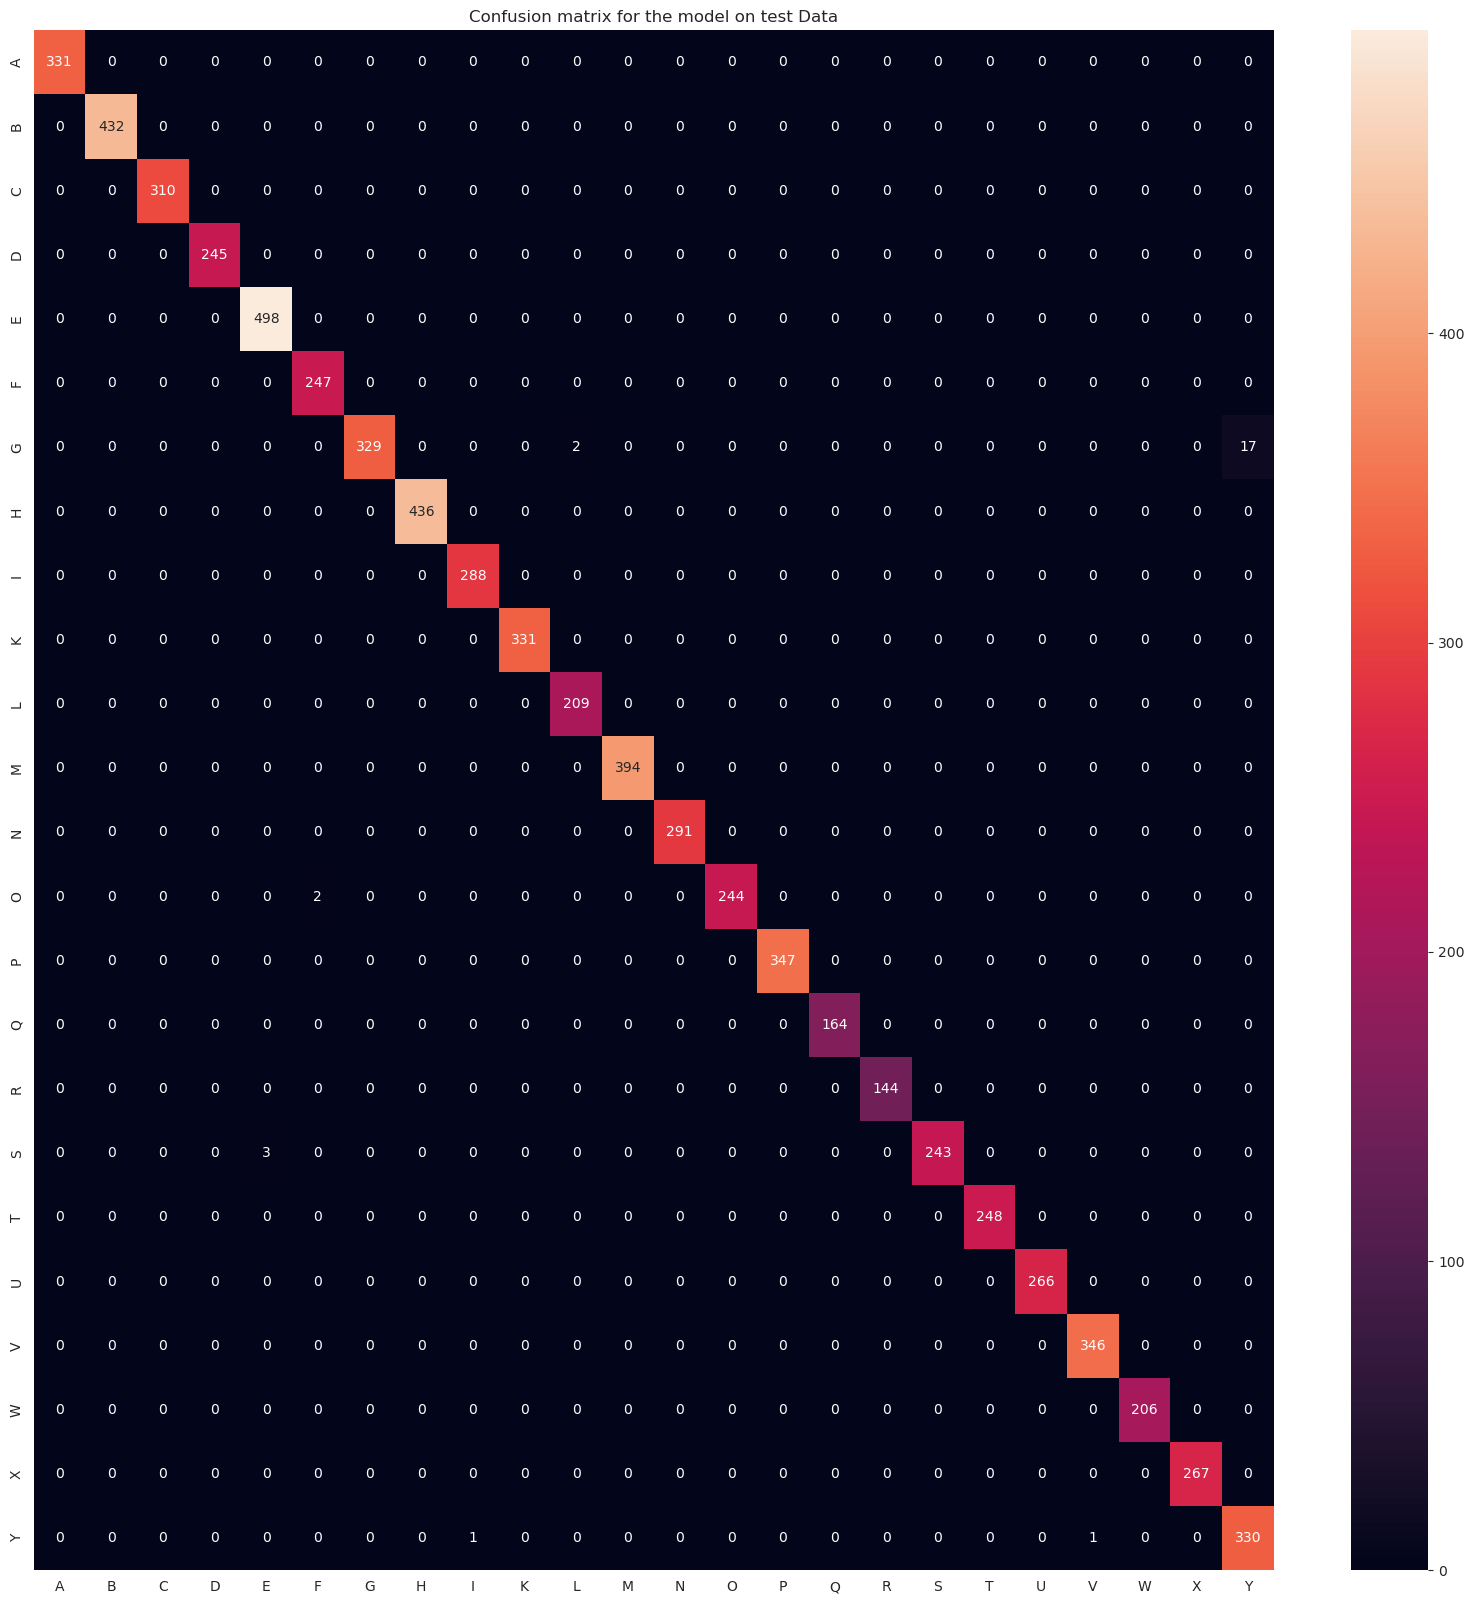

In [22]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, ax=ax , fmt='d')
ax.set_title('Confusion matrix for the model on test Data')
plt.show()

In [23]:
print(classification_report(y_true=test_df['Label_name'], y_pred=test_df['Predicted_name']))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       331
           B       1.00      1.00      1.00       432
           C       1.00      1.00      1.00       310
           D       1.00      1.00      1.00       245
           E       0.99      1.00      1.00       498
           F       0.99      1.00      1.00       247
           G       1.00      0.95      0.97       348
           H       1.00      1.00      1.00       436
           I       1.00      1.00      1.00       288
           K       1.00      1.00      1.00       331
           L       0.99      1.00      1.00       209
           M       1.00      1.00      1.00       394
           N       1.00      1.00      1.00       291
           O       1.00      0.99      1.00       246
           P       1.00      1.00      1.00       347
           Q       1.00      1.00      1.00       164
           R       1.00      1.00      1.00       144
           S       1.00    

In [24]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array = np.insert(predictions_array, 9, 0)
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                        100*np.max(predictions_array),
                                        class_names[true_label]),
                                        color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array = np.insert(predictions_array, 9, 0)
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(NUM_CLASSES+1), class_names[:-1])
    plt.yticks([])
    thisplot = plt.bar(range(NUM_CLASSES+1), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

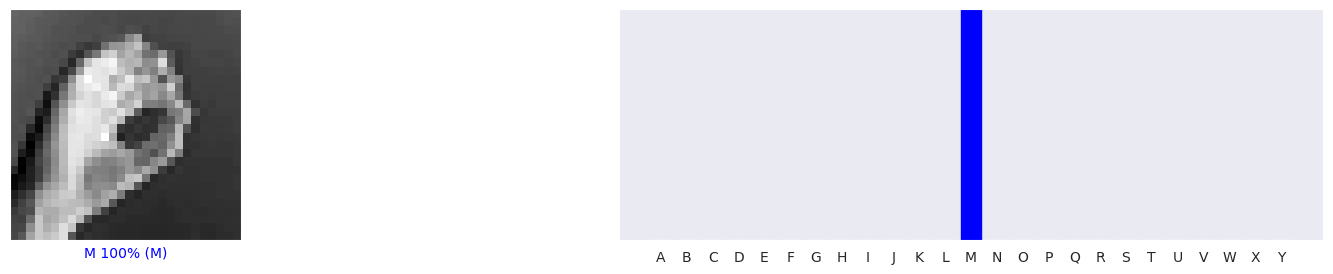

In [42]:
i = 2100
plt.figure(figsize=(20,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_train)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

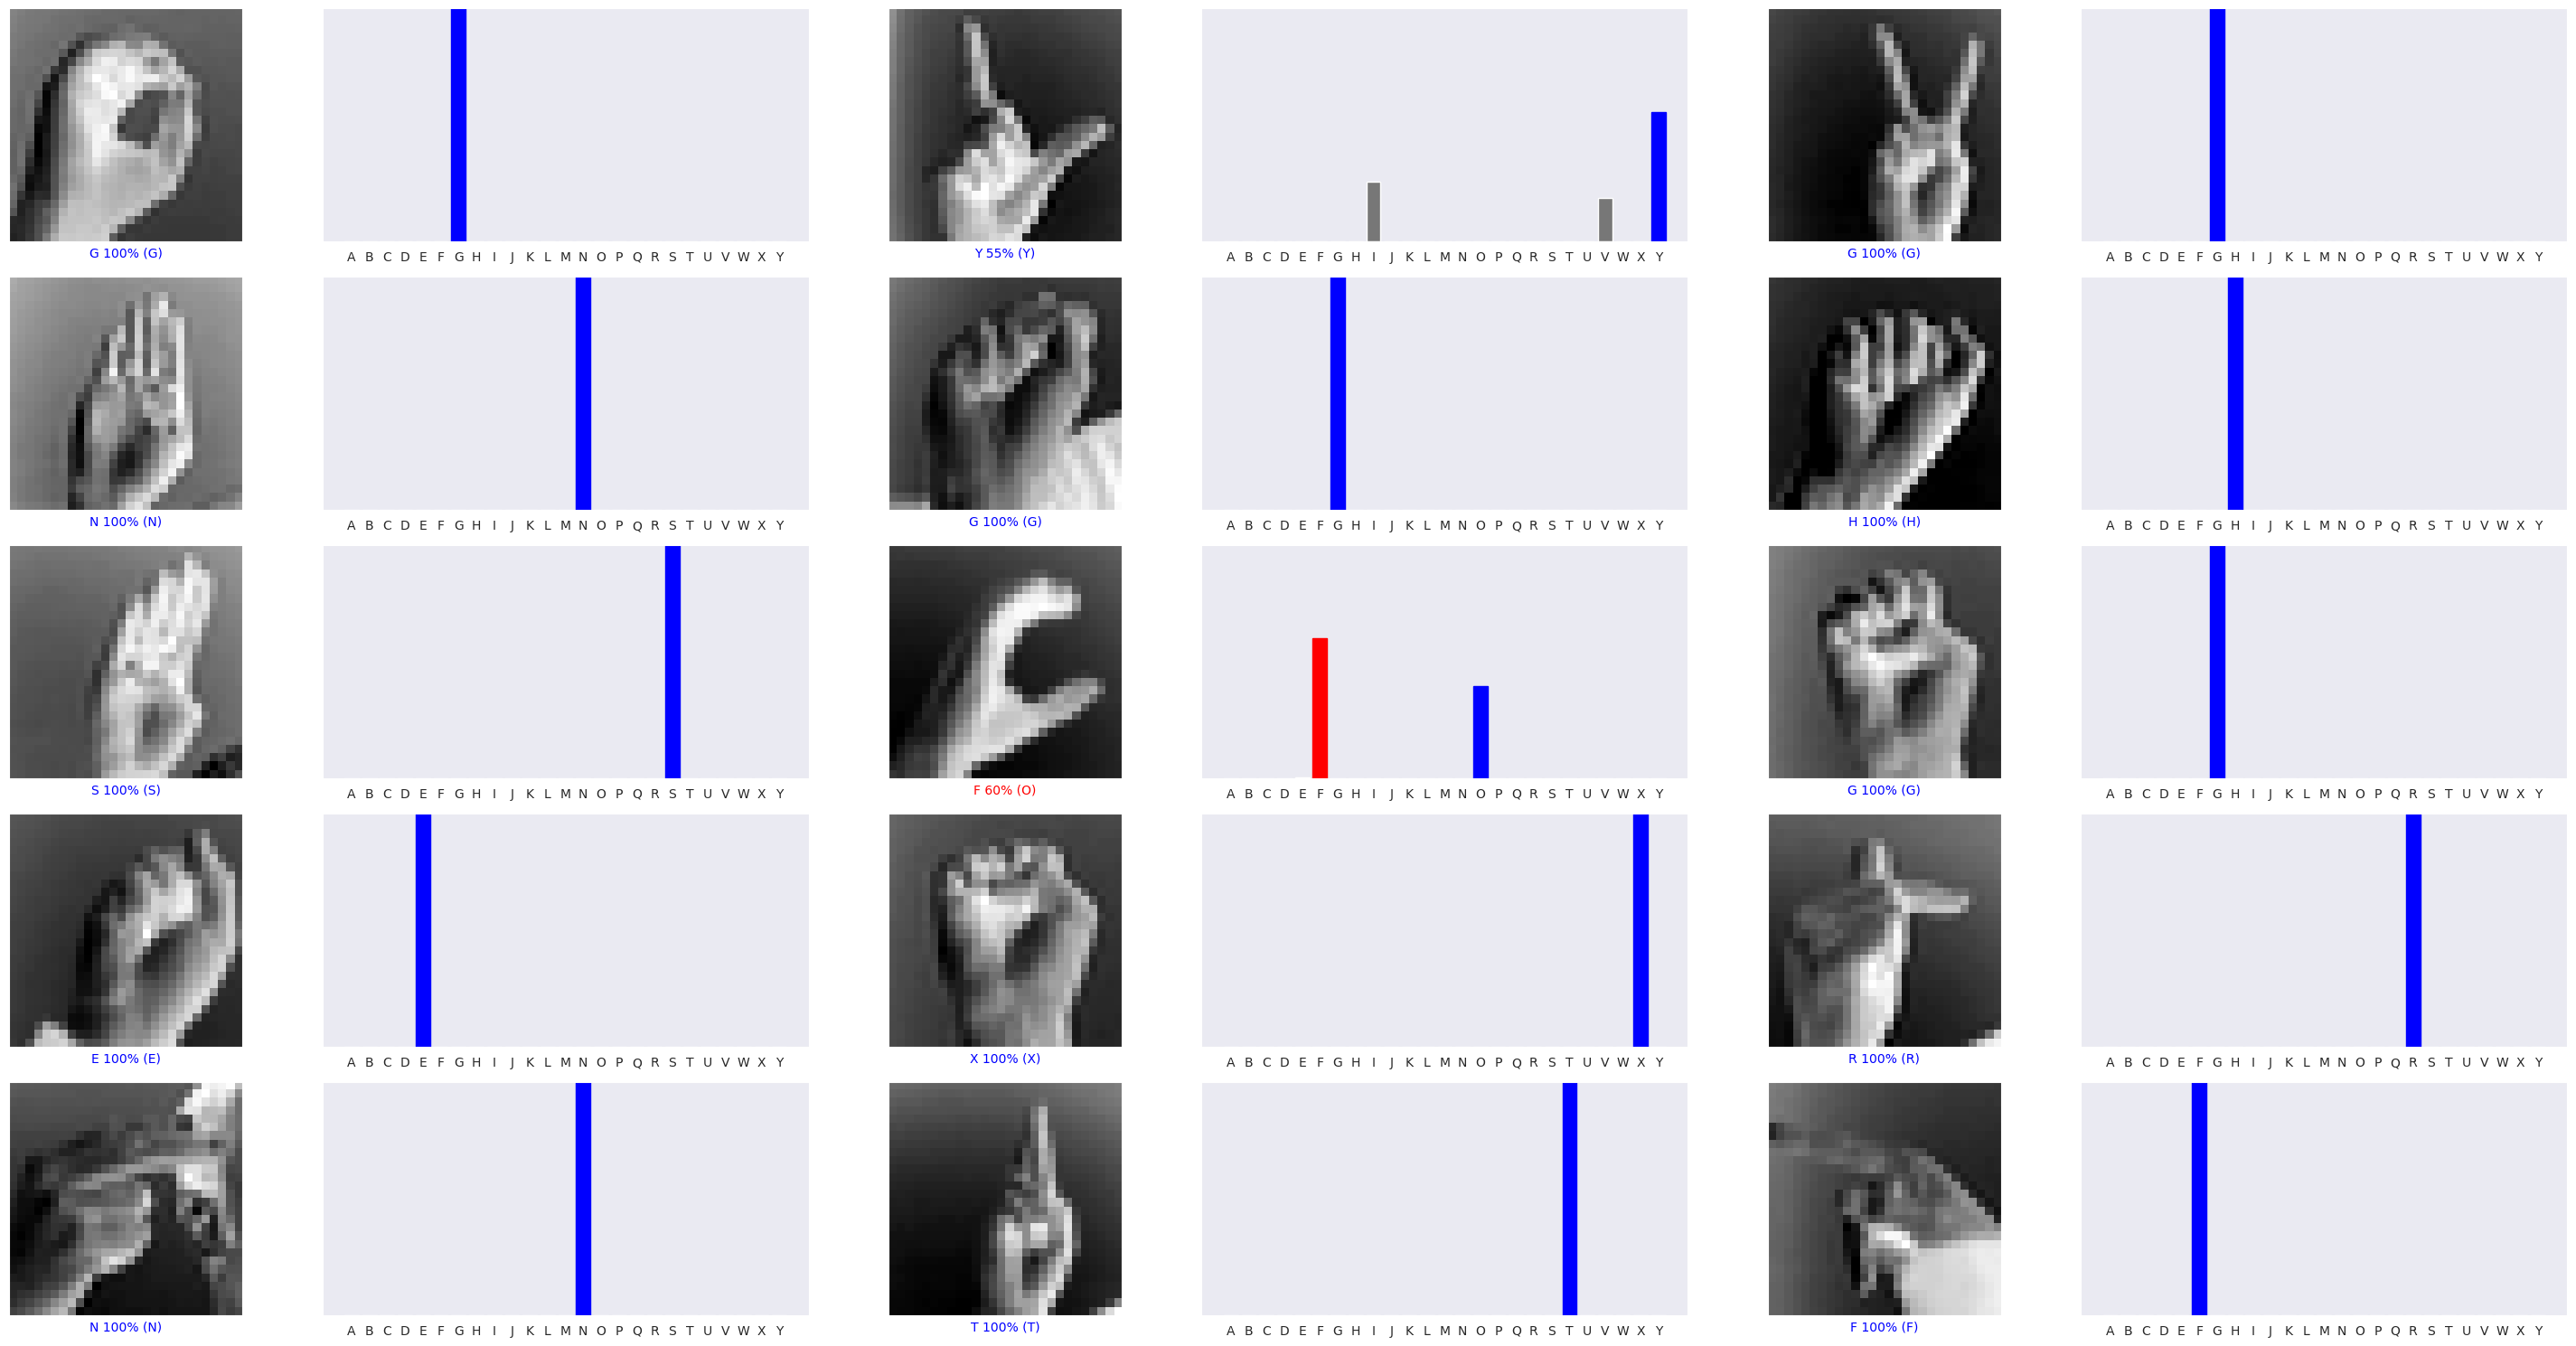

In [45]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*5*num_cols, 2*num_rows+5))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+2668, predictions[i+2668], y_test, X_train)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+2668, predictions[i+2668], y_test)
plt.tight_layout()
plt.show()

# End
## [GitHup](https://github.com/ahmedAEAID) | [LinkedIn](https://www.linkedin.com/in/ahmed-mohamed-abd-elkader-ml/) | [Kaggle](https://www.kaggle.com/ahmedmoabdelkader/)